In [21]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Import additional library to properply play videos on jupyter notebook
from IPython.display import clear_output


In [22]:
capR = cv2.VideoCapture('robotR.avi')
capL = cv2.VideoCapture('robotL.avi')
print(capR,capL)

<VideoCapture 102D2150> <VideoCapture 0C9783A0>


True True
average of the disparity -16.0
depth -3269.4117


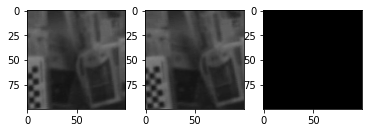

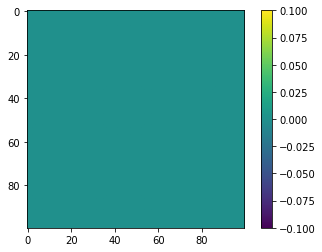

average of the disparity -16.0
depth -3269.4117


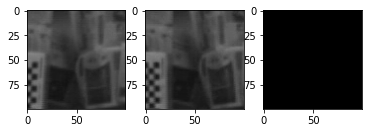

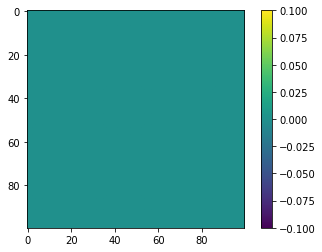

average of the disparity -16.0
depth -3269.4117


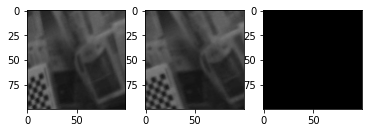

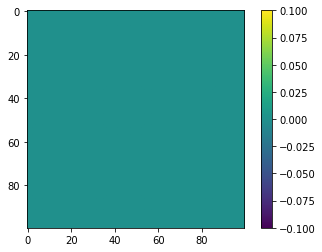

average of the disparity -16.0
depth -3269.4117


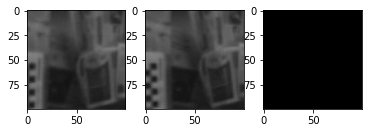

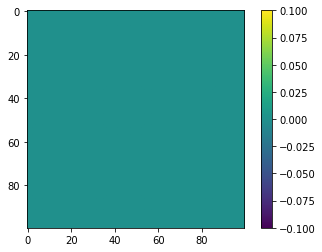

average of the disparity -16.0
depth -3269.4117


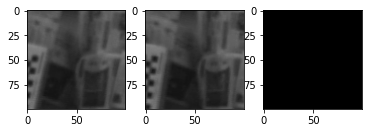

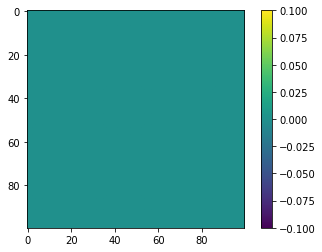

average of the disparity -16.0
depth -3269.4117


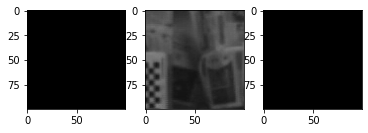

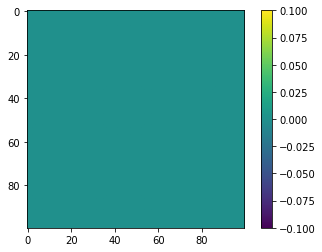

average of the disparity -16.0
depth -3269.4117


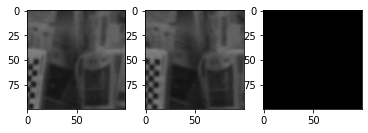

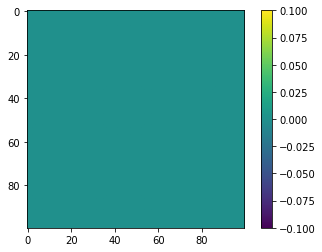

average of the disparity -16.0
depth -3269.4117


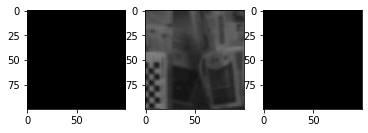

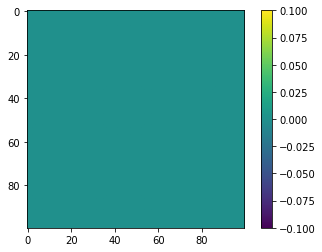

average of the disparity -16.0
depth -3269.4117


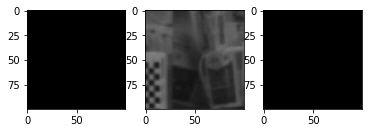

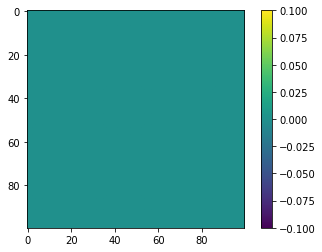

average of the disparity -16.0
depth -3269.4117


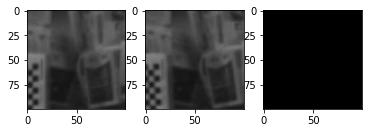

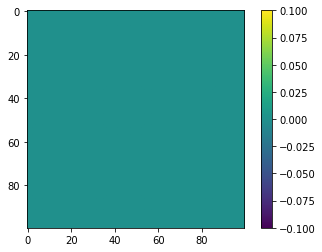

average of the disparity -16.0
depth -3269.4117


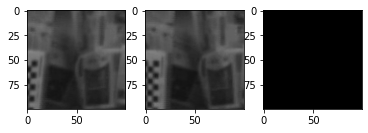

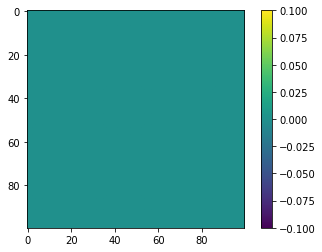

average of the disparity -16.0
depth -3269.4117


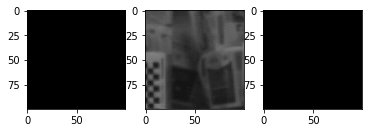

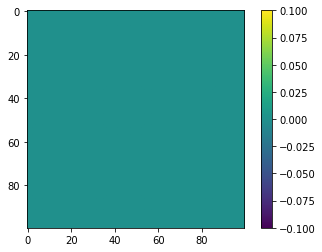

average of the disparity -16.0
depth -3269.4117


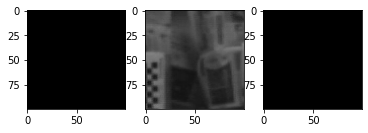

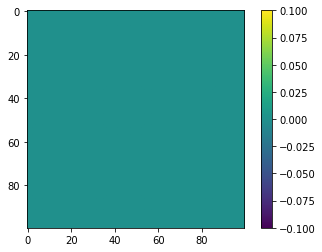

average of the disparity -16.0
depth -3269.4117


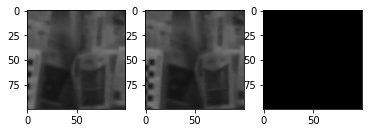

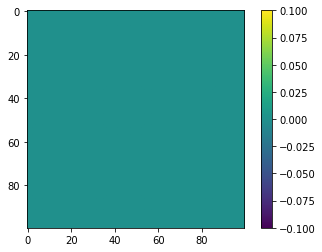

average of the disparity -16.0
depth -3269.4117


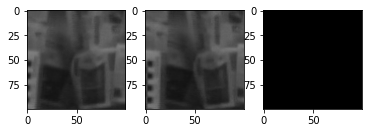

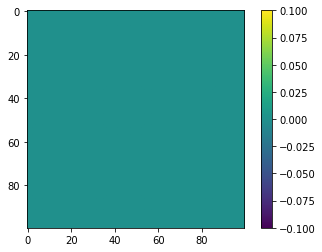

average of the disparity -16.0
depth -3269.4117


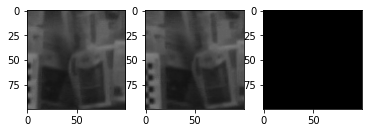

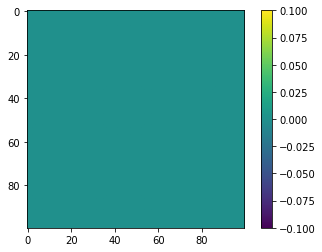

average of the disparity -16.0
depth -3269.4117


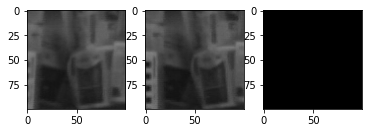

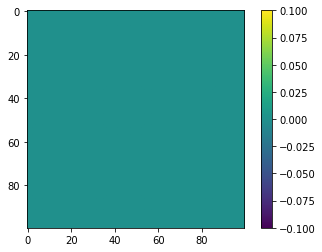

average of the disparity -16.0
depth -3269.4117


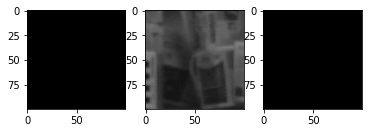

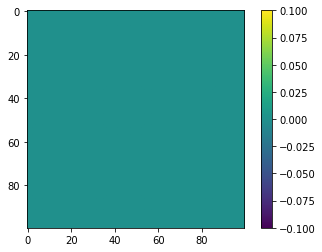

average of the disparity -16.0
depth -3269.4117


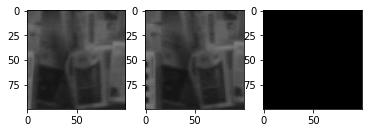

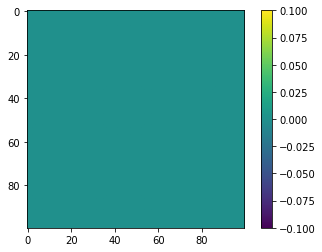

average of the disparity -16.0
depth -3269.4117


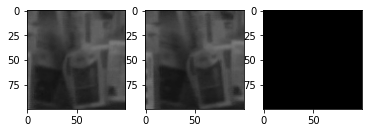

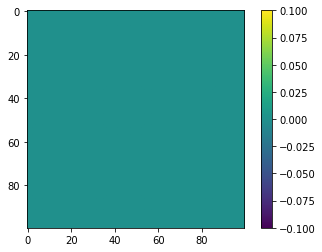

average of the disparity -16.0
depth -3269.4117


KeyboardInterrupt: 

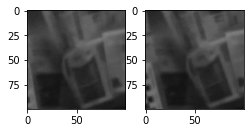

In [23]:

print(capR.isOpened(),capL.isOpened())
while (capR.isOpened() and capL.isOpened()):
    retL, frameL = capL.read()
    retR, frameR = capR.read()
    imgR = cv2.cvtColor(frameR,cv2.COLOR_BGR2GRAY)
    
    #imgR = imgR[100:400, 100:400]
    imgL = cv2.cvtColor(frameL,cv2.COLOR_BGR2GRAY)
    #imgL = imgL[100:400, 100:400]
    
    
    sift= cv2.xfeatures2d.SIFT_create()
    kpL, desL = sift.detectAndCompute(imgL, None)
    kpR, desR = sift.detectAndCompute(imgR, None)
    imgSift = cv2.drawKeypoints(
        imgL, kpL, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #cv2.imshow("SIFT Keypoints", imgSift)
    #cv2.waitKey(100)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desL, desR, k=2)
    matchesMask = [[0, 0] for i in range(len(matches))]
    
    good = []
    ptsL = []
    ptsR = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i] = [1, 0]
            good.append(m)
            ptsR.append(kpR[m.trainIdx].pt)
            ptsL.append(kpL[m.queryIdx].pt)
            
    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask[300:500],
                       flags=cv2.DrawMatchesFlags_DEFAULT)
    keypoint_matches = cv2.drawMatchesKnn(
        imgL, kpL, imgR, kpR, matches[300:500], None, **draw_params)
    #cv2.imshow("Keypoint matches", keypoint_matches)
    #cv2.waitKey(5000)
    
    ptsL = np.int32(ptsL)
    ptsR = np.int32(ptsR)
    fundamental_matrix, inliers = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_RANSAC)
    
    # We select only inlier points
    ptsL = ptsL[inliers.ravel() == 1]
    ptsR = ptsR[inliers.ravel() == 1]
    
    def drawlines(imgLsrc, imgRsrc, lines, ptsLsrc, ptsRsrc):
        r, c = imgLsrc.shape
        imgLcolor = cv2.cvtColor(imgLsrc, cv2.COLOR_GRAY2BGR)
        imgRcolor = cv2.cvtColor(imgRsrc, cv2.COLOR_GRAY2BGR)
        
        np.random.seed(1)
        for r, ptL, ptR in zip(lines, ptsLsrc, ptsRsrc):
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = map(int, [0, -r[2]/r[1]])
            x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
            img1color = cv2.line(imgLcolor, (x0, y0), (x1, y1), color, 1)
            img1color = cv2.circle(imgLcolor, tuple(ptL), 5, color, -1)
            img2color = cv2.circle(imgRcolor, tuple(ptR), 5, color, -1)
        return imgLcolor, imgRcolor
    
    
    linesL = cv2.computeCorrespondEpilines(
        ptsR.reshape(-1, 1, 2), 2, fundamental_matrix)
    linesL = linesL.reshape(-1, 3)
    img5, img6 = drawlines(imgL, imgR, linesL, ptsL, ptsR)
    linesR = cv2.computeCorrespondEpilines(
        ptsL.reshape(-1, 1, 2), 1, fundamental_matrix)
    
    linesR = linesR.reshape(-1, 3)
    
    img3, img4 = drawlines(imgR, imgL, linesR, ptsR, ptsL)
    
    #plt.subplot(121), plt.imshow(img5)
    #plt.subplot(122), plt.imshow(img3)
    #plt.suptitle("Epilines in both images")
    #plt.show()
    

    #cv2.imwrite("rectified_left.png", imgL_rectified)
    #cv2.imwrite("rectified_right.png", imgR_rectified)

    h1, w1 = imgL.shape
    h2, w2 = imgR.shape
    _, H1, H2 = cv2.stereoRectifyUncalibrated(
        np.float32(ptsL), np.float32(ptsR), fundamental_matrix, imgSize=(w1, h1)
    )
    
    imgL_rectified = cv2.warpPerspective(imgL, H1, (w1, h1))
    imgR_rectified = cv2.warpPerspective(imgR, H2, (w2, h2))

    
    ###cv2.imwrite("rectified_Lpng", imgL_rectified)
    ###cv2.imwrite("rectified_R.png", imgR_rectified)
    
    #fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    #axes[0].imshow(img1_rectified, cmap="gray")
    
    #axes[1].imshow(img2_rectified, cmap="gray")
    #axes[0].axhline(250)
    #axes[1].axhline(250)
    #axes[0].axhline(450)
    #axes[1].axhline(450)
    #plt.suptitle("Rectified images")
    #plt.savefig("rectified_images.png")
    #plt.show()
    
    #disparity mapping part
    ###rectified_1= cv2.imread('rectified_L.png')
    ###rectified_2= cv2.imread('rectified_R.png')
    rectified_1= imgL_rectified
    rectified_2= imgR_rectified
    imgL1=rectified_1[rectified_1.shape[0]//2-50:rectified_1.shape[0]//2+50,rectified_1.shape[1]//2-50:rectified_1.shape[1]//2+50]
    imgR1=rectified_2[rectified_2.shape[0]//2-50:rectified_2.shape[0]//2+50,rectified_2.shape[1]//2-50:rectified_2.shape[1]//2+50]

    
    # Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
    block_size = 1
    min_disp = 0
    max_disp = 128
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
    num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
    uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
    speckleWindowSize = 200
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
    speckleRange = 2
    disp12MaxDiff = 0

    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=block_size,
        uniquenessRatio=uniquenessRatio,
        speckleWindowSize=speckleWindowSize,
        speckleRange=speckleRange,
        disp12MaxDiff=disp12MaxDiff,
        P1=8 * 1 * block_size * block_size,
        P2=32 * 1 * block_size * block_size,
    )
    disparity_SGBM = stereo.compute(imgR1, imgL1)
    cv2.imshow('disparity', disparity_SGBM)
    cv2.waitKey(50)
    
    avg = np.average(disparity_SGBM)
    print("average of the disparity",avg)
    b=92.226
    f=567.2
    numerator= b*f
    z= numerator/avg
    print("depth",z)
    
# Normalize the values to a range from 0..255 for a grayscale image
    disparity_SGBM = cv2.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv2.NORM_MINMAX)
    disparity_SGBM = np.uint8(disparity_SGBM)
    cv2.imshow("Disparity", disparity_SGBM)
    cv2.imwrite("disparity_SGBM_norm.png", disparity_SGBM)
    #colored disparity map
    
    plt.subplot(1,3,1)
    plt.imshow(imgL1, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1,3,2)
    plt.imshow(imgR1, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1,3,3)
    plt.imshow(disparity_SGBM ,cmap='gray', vmin=0, vmax=255)
    plt.show() 

    plt.imshow(disparity_SGBM, cmap='viridis')
    plt.colorbar()
    plt.show()

### 










